In [146]:
# need to run this twice due to bug in imported package

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils
from catomatic.CatalogueBuilder import BuildCatalogue

from sklearn.model_selection import ShuffleSplit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import piezo

from protocols.predict_2 import piezo_predict

import warnings

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
shaheed = pd.read_pickle('./data/shaheed/MUTATIONS.pkl.gz').reset_index()
shaheed[(shaheed.IN_PROMOTER == True)]

,UNIQUEID,GENE,MUTATION,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,...,IS_HET,IS_NULL,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES
29,site.10.subj.BH02818474.lab.BH02818474.iso.1,PE_PGRS38,t-87c,-87.0,NaN,2424925.0,-87.0,t,c,True,...,False,False,True,GENE,SNP,NaN,,,10,0
112,site.10.subj.BH02818474.lab.BH02818474.iso.1,Rv0021c,g-78c,-78.0,NaN,26959.0,-78.0,g,c,True,...,False,False,True,LOCUS,SNP,NaN,,,10,0
122,site.10.subj.BH02818474.lab.BH02818474.iso.1,Rv0108c,-70_indel,-70.0,NaN,131174.0,-70.0,,,False,...,False,False,True,LOCUS,INDEL,1.0,-70_ins,-70_ins_1,10,0
147,site.10.subj.BH02818474.lab.BH02818474.iso.1,Rv0383c,t-84g,-84.0,NaN,459399.0,-84.0,t,g,True,...,False,False,True,LOCUS,SNP,NaN,,,10,0
154,site.10.subj.BH02818474.lab.BH02818474.iso.1,Rv0518,t-68g,-68.0,NaN,610120.0,-68.0,t,g,True,...,False,False,True,LOCUS,SNP,NaN,,,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679972,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,vapB1,-5_indel,-5.0,NaN,71584.0,-5.0,,,False,...,False,False,True,GENE,INDEL,37.0,-5_ins,-5_ins_37,10,0
1679974,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,vapB24,a-9g,-9.0,NaN,289095.0,-9.0,a,g,True,...,False,False,True,GENE,SNP,NaN,,,10,0
1679981,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,wbbL2,c-21t,-21.0,NaN,1719996.0,-21.0,c,t,True,...,False,False,True,GENE,SNP,NaN,,,10,0
1679982,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,whiB6,-74_indel,-74.0,NaN,4338595.0,-74.0,,,False,...,False,False,True,GENE,INDEL,-1.0,-74_del,-74_del_1,10,0


# Import the source data from CRyPTIC and NICD

All these data tables were extracted from the CRyPTIC tables v2.1.1. To save space, the MUTATIONS table has been subsetted down to only include mutations in mmpL5, pepQ, Rv0678, atpE and mmpS5. CRyPTIC v2.1.1 was created on 20 March 2024.

In [2]:
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz", index_col=0)
phenotypes_cryptic_samples = set(phenotypes_cryptic.index)

phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz", index_col=0)
phenotypes_nicd_samples = set(phenotypes_nicd.index)

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz', index_col=0)

mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)

mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

genomes = pd.read_csv("./data/GENOMES.csv.gz", index_col=0)
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

In [3]:

print(f"The CRyPTIC project has {phenotypes_cryptic.index.nunique()} unique isolates with a BDQ DST measurement\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]

print(f"Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to {phenotypes_cryptic.index.nunique()}.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']

print(f"Accepting those where more than one method agree on the MIC leaves {phenotypes_cryptic.index.nunique()} samples.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.index.isin(genomes.index)]

print(f"..and of those only {phenotypes_cryptic.index.nunique()} samples also underwent WGS.")

assert phenotypes_cryptic.index.nunique() == len(phenotypes_cryptic.index), 'one or more samples have more than one DST measurement!'

The CRyPTIC project has 21178 unique isolates with a BDQ DST measurement

Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to 21057.

Accepting those where more than one method agree on the MIC leaves 14605 samples.

..and of those only 10704 samples also underwent WGS.



The CRyPTIC project has 21178 unique isolates with a BDQ DST measurement

Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to 21057.

Accepting those where more than one method agree on the MIC leaves 14605 samples.

..and of those only 10704 samples also underwent WGS.
If we look at the final group of samples which (i) went on an UKMYC plate, (ii) had two or more methods agree on the MIC and (iii) underwent WGS

In [4]:
pd.crosstab(phenotypes_cryptic.METHOD_3, phenotypes_cryptic.PHENOTYPE, margins=True)

PHENOTYPE,R,S,All
METHOD_3,,,
UKMYC5,29,4387,4416
UKMYC6,54,6234,6288
All,83,10621,10704


In [5]:
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].index

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(has_mgit)]

print(f"The NICD dataset has {phenotypes_nicd.index.nunique()} unique isolates with a BDQ MGIT960 DST measurement\n")

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(genomes.index)]

print(f".. and of those {phenotypes_nicd.index.nunique()} also underwent WGS ..\n")

print(f".. of these {phenotypes_nicd[(phenotypes_nicd.PHENOTYPE=='R')].index.nunique()} are resistant to BDQ according at least one method\n")

# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd.reset_index(inplace=True)
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)
phenotypes_nicd.reset_index(drop=True, inplace=True)
phenotypes_nicd.set_index('UNIQUEID',inplace=True)

The NICD dataset has 1168 unique isolates with a BDQ MGIT960 DST measurement

.. and of those 1163 also underwent WGS ..

.. of these 783 are resistant to BDQ according at least one method



Now we can look at how these are split between the DST methods



In [6]:
pd.crosstab(phenotypes_nicd.PHENOTYPE, phenotypes_nicd.METHOD_CC, margins=True)     

METHOD_CC,1.0,WHO,All
PHENOTYPE,,,
R,472,311,783
S,139,241,380
All,611,552,1163


In [7]:
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"

phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 

assert phenotypes.index.nunique() == len(phenotypes.index), 'one or more samples have more than one DST measurement!'

print(f"The combined dataset has {len(phenotypes)} samples with a BDQ DST result and WGS data")

The combined dataset has 11867 samples with a BDQ DST result and WGS data


In [8]:
pd.crosstab(phenotypes.PHENOTYPE, phenotypes.METHOD_3, margins=True)

METHOD_3,MGIT960,UKMYC5,UKMYC6,All
PHENOTYPE,,,,
R,783,29,54,866
S,380,4387,6234,11001
All,1163,4416,6288,11867


# Data prep for catalogue building

In [9]:
# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()
# cat_mutations.reset_index(inplace=True)

# Merge genomes and phenotypes tables
samples = phenotypes.join(genomes, how="inner")[["DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)

We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them.

# Basic Numbers (at FRS 0.75)

## Non-wt samples - used to build catalogues

In [10]:
all_cat = cat_mutations.join(samples, how='inner')
all_cat.reset_index(inplace=True)
utils.combined_data_table((all_cat[all_cat.FRS>=0.75]))

All               Minor alleles             All                \
          R      S  Total             R   S Total     R      S  Total   
Total   860  10897  11757            62  57   119  2151  21465  23616   
Rv0678  533    364    897            57  19    76   554    374    928   
mmpL5   859  10895  11754             5  36    41  1572  20638  22210   
pepQ     13    150    163             1   2     3    13    361    374   
mmpS5     1     56     57             0   0     0     1     59     60   
atpE     11     14     25             3   1     4    11     33     44   

       Minor alleles            
                   R   S Total  
Total             67  66   133  
Rv0678            57  19    76  
mmpL5              6  44    50  
pepQ               1   2     3  
mmpS5              0   0     0  
atpE               3   1     4

Nearly all non-wt samples contain an mmpL5 non-synonymous variants - this corresponds to 22210 total mutations in mmpL5

## All samples - used to test catalogues (include wt and synonymous)


In [11]:
all = mutations.join(samples, how='right')
all['GENE'].fillna('None', inplace=True)
all.reset_index(inplace=True)
utils.combined_data_table((all[all.FRS>=0.25]))

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   861  10906  11767           239  245   484  2463  22747  25210   
Rv0678  689    431   1120           225   74   299   805    474   1279   
mmpL5   860  10901  11761             7  133   140  1620  21342  22962   
pepQ     20    255    275             8   46    54    22    679    701   
mmpS5     4     79     83             2    2     4     4     83     87   
atpE     12     30     42             3    6     9    12    169    181   

       Minor alleles             
                   R    S Total  
Total            332  441   773  
Rv0678           307   95   402  
mmpL5             10  187   197  
pepQ              10   47    57  
mmpS5              2    2     4  
atpE               3  110   113

# Test the WHO catalogue on our dataset

The WHO have achieved a maximum sensitivity of 59.6% - but this was constructed and validated on their pooled dataset. Therefore, let's test on our dataset, which contains new NICD samples which they didn't have access to:

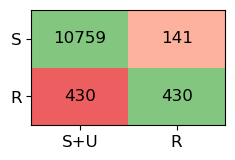

In [12]:
cm, _cov, _who_sens_75, _who_spec_75, _FN_ids = piezo_predict(all[all.FRS>=0.75], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True)

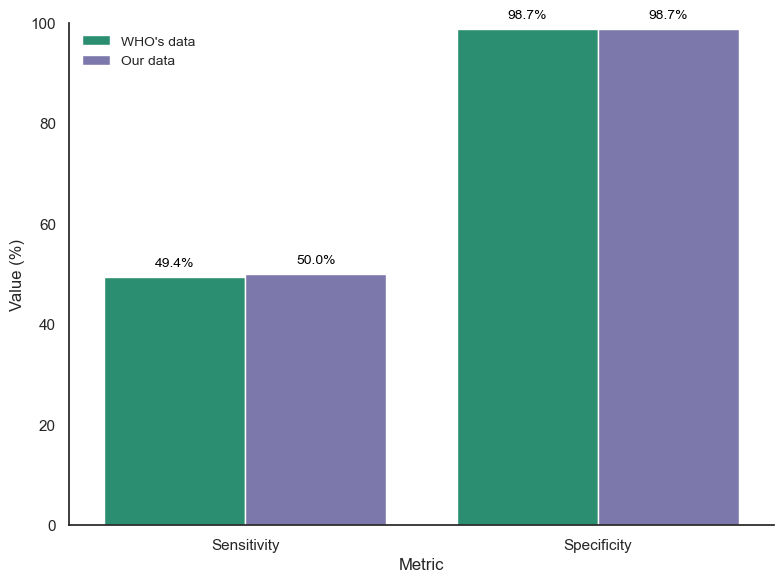

In [13]:
performance = {
    "WHO's data":{"Sensitivity": 49.4, "Specificity": 98.7},
    'Our data':{"Sensitivity": _who_sens_75*100, "Specificity": _who_spec_75*100}
}

utils.compare_metrics(performance)

There is no difference.

These values were achieved at an FRS = 0.75, however the WHO differentiate between testing at 0.75 and 0.25.

Therefore, what does this look like at FRS 0.25....

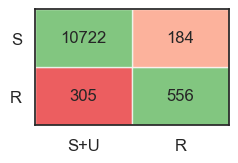

In [14]:
cm, _cov, _who_sens_25, _who_spec_25, _FN_ids = piezo_predict(all[all.FRS>=0.25], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True)

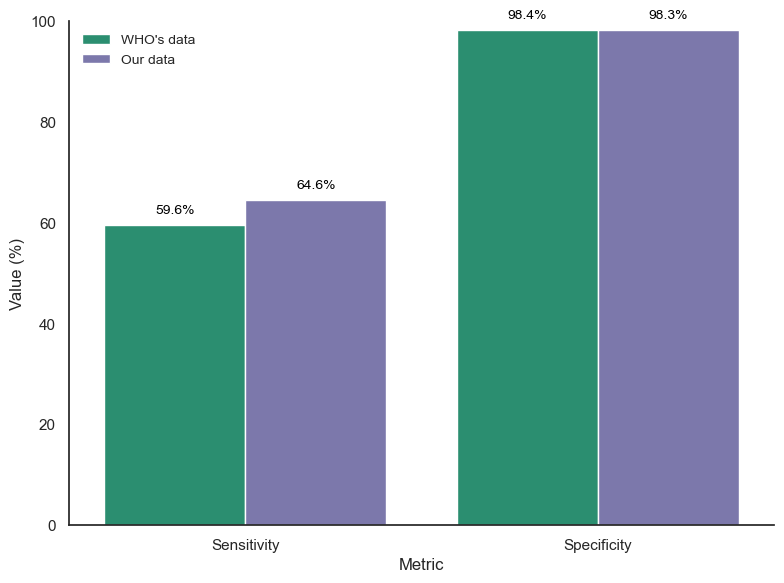

In [15]:
performance = {
    "WHO's data":{"Sensitivity": 59.6, "Specificity": 98.4},
    'Our data':{"Sensitivity": _who_sens_25*100, "Specificity": _who_spec_25*100}
}

utils.compare_metrics(performance)

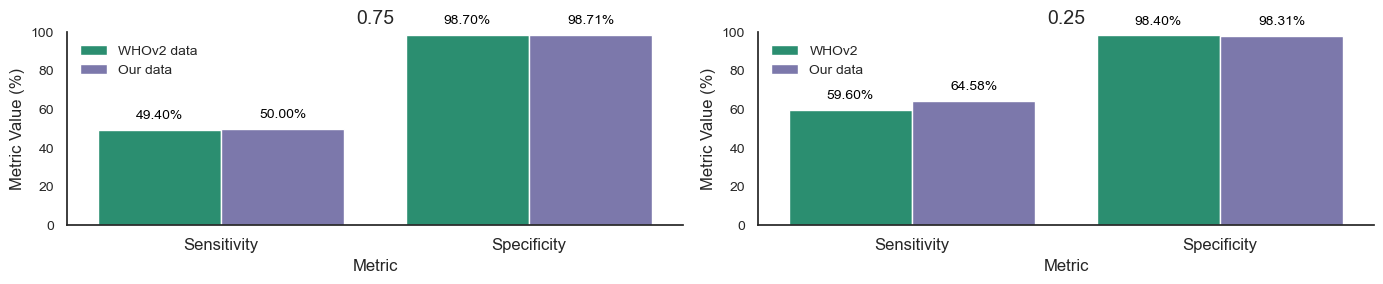

In [16]:
# combine performance charts into one axis
performance = {
    0.75: {
        "WHOv2 data": {"Sensitivity": 49.4, "Specificity": 98.7},
        "Our data": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    },
    0.25: {
        "WHOv2": {"Sensitivity": 59.6, "Specificity": 98.4},
        "Our data": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
    },
}

utils.compare_metrics_groups(performance)

Validating at FRS 0.25 does give a boost, as additional variants catalogued as resistant were sequenced with lower read support.

The WHO's approach uses conservative statistical thresholds and a complex, stringent confidence grading system. This can perhaps be justified if one has tonnes of data and a good R population, but that's not really the case for bedaquiline. We suspect this strict approach misses resistant variants, thereby limiting sensitivity.

We have therefore developed our own, simpler algorithm...

# Construct new catalogues

Our algorithm, of which the underlying statistics and logic are discussed in `methods.ipynb`, is more permissive in its approach - it contains considerably fewer statistical filters and thresholds while retaining an iterative mechanism that unlocks susceptible variants. This mechanism is also allowed to run to completion (unlike WHOv2) - the deeper the algorithm searches, we accept the potential hit on specificity in favour of gathering maximum evidence.



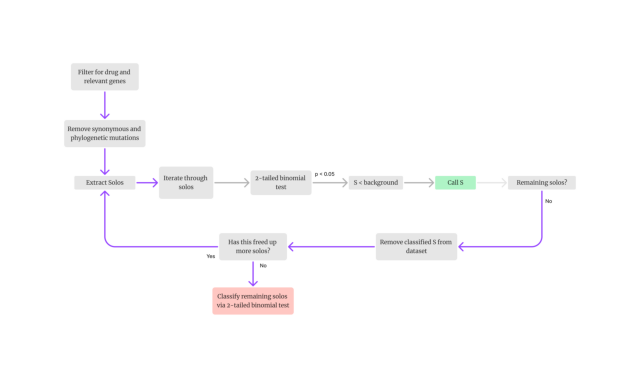

In [34]:
img = mpimg.imread('./imgs/manuscript_2/bdq_workflow.png')
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

We have developed a catalogue construction tool, `catomatic`, which allows easy implementation of the above method (and alternatives), and ensures complete reproducibility. It also also allows flexibility of parameter space - ie we can slide the FRS when constructing the catalogues (not just when validating) and we can seed the method with known phylogenetic mutations (which are neutral and otherwise add considerable noise).

Owing to limitations of the data discussed in `methods.ipynb`, our catalogue (like WHOv2) is a comprehensive list of resistant varians, as oppose to a table of both R and S mutations, which would be clinically more useful.

We are also going to build our catalogues on a dataset injected with novel, highly resistant samples.

## Build and test our catalogue at FRS 0.75

Owing to their extremely high prevelance and literature evidence (DOI: 10.1186/s13073-020-00726-5), I948V and T794I are considered phylogenetic and assumed to be neutral.

Mirroring the WHO, we can construct our catalogue at FRS 0.75 and test it at FRS 0.75...

However, we will remove mmpL5 and mmpS5 owing to the fact they contain no resistant varians (methods.ipynb), and do not appear in the catalogue if included. They therefore just add noise.

In [14]:
samples.reset_index(inplace=True)
cat_mutations.reset_index(inplace=True)
mutations.reset_index(inplace=True)
#remove mmpL5 and mmpS5 from dataset.
cat_mutations = cat_mutations[~cat_mutations.MUTATION.isin(['mmpL5', 'mmpS5'])]
all = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])], how='left', on='UNIQUEID')
#there will not be samples with no mutations and blank rows
all.FRS.fillna(1, inplace=True)

#build catalogue at FRS 0.75
catalogue_75 = BuildCatalogue(samples=samples, mutations=cat_mutations, FRS=0.75, tails='two', seed=['mmpL5@I948V', 'mmpL5@T794I'], test='Binomial', background=0.1, strict_unlock=True)
#display in piezo format
catalogue_75.build_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards)

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,{},"{""seeded"": ""True""}",{}
1,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,{},"{""seeded"": ""True""}",{}
2,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@D767N,S,{},"[{""proportion"": 0.015419209765499518, ""confide...",{}
3,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@F696L,S,{},"[{""proportion"": 0.0, ""confidence"": [3.27005367...",{}
4,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@Y300!,S,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.027...",{}
...,...,...,...,...,...,...,...,...,...,...,...
504,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
505,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
506,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
507,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


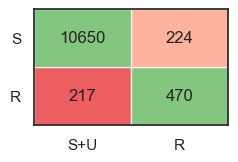

In [34]:
#export to piezo file
catalogue_75.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')

#test at FRS 0.75
cm, _cov, _sens_75, _spec_75, _FN_ids = piezo_predict(all[all.FRS>=0.75], f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True)

At FRS 0.75 we see a marginal improvement than the WHO.

However, they do get an increase when testing at FRS 0.25, so let's try that...

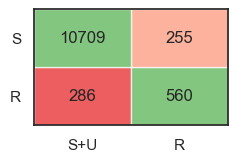

In [35]:
#test at FRS 0.25
cm, _cov, _sens_25, _spec_25, _FN_ids = piezo_predict(all[all.FRS>=0.25], f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True)

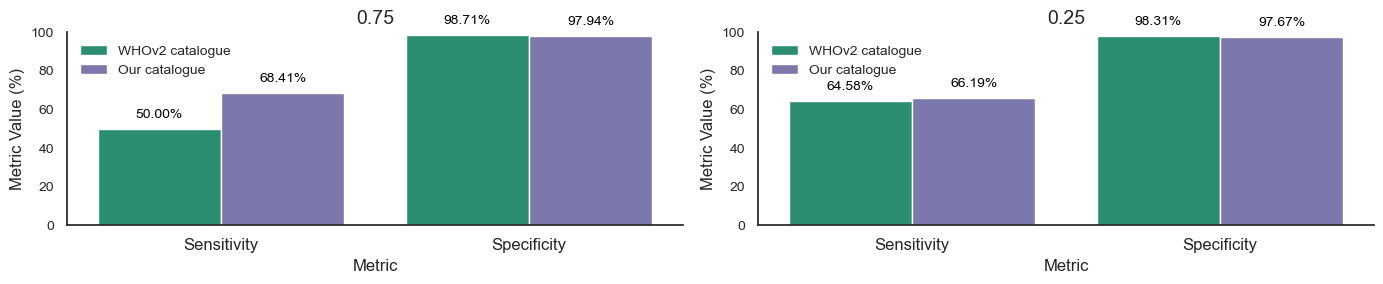

In [36]:
performance = {
    0.75: {
        "WHOv2 catalogue": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
        "Our catalogue": {"Sensitivity": _sens_75 * 100, "Specificity": _spec_75 * 100},
    },
    0.25: {
        "WHOv2 catalogue": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
        "Our catalogue": {"Sensitivity": _sens_25 * 100, "Specificity": _spec_25 * 100},
    },
}

utils.compare_metrics_groups(performance)

When validating on the same dataset, our catalogue achieves comparable performance to the WHO's with a marginal increase. 

Note, that our catalogue table contains the following classification counts:



In [37]:
catalogue_dict = catalogue_75.return_catalogue()
catalogue_dict = {k: v for k, v in catalogue_dict.items() if 'seeded' not in v['evid']}

R = sum(1 for v in catalogue_dict.values() if v['pred'] == 'R')
S = sum(1 for v in catalogue_dict.values() if v['pred'] == 'S')
U = sum(1 for v in catalogue_dict.values() if v['pred'] == 'U')

print ('Resistant classification counts: \n\n', R)
print ('Susceptible classification counts: \n\n', S)
print ('Unclassified classification counts: \n\n', U)

Resistant classification counts: 

 66
Susceptible classification counts: 

 10
Unclassified classification counts: 

 431


Owing to the vast number of U's (their derivation is explored in `methods.ipynb`), we would expect a considerable number of 'unknown predictions' under the prediction protocol we are using. However, for comparative purposes we are mirroring WHOv2 and assuming these are susceptible when making the sample-level predictions. This is not necessarily a justifiable approach for BDQ (refer to `methods.ipynb`), and is adapted to a more suitable protocl later in this section.

This is an encouraging start, as our catalogue at the very least performs similarly, but is also constructed using a much simpler, more permissive, and completely reproducible approach.

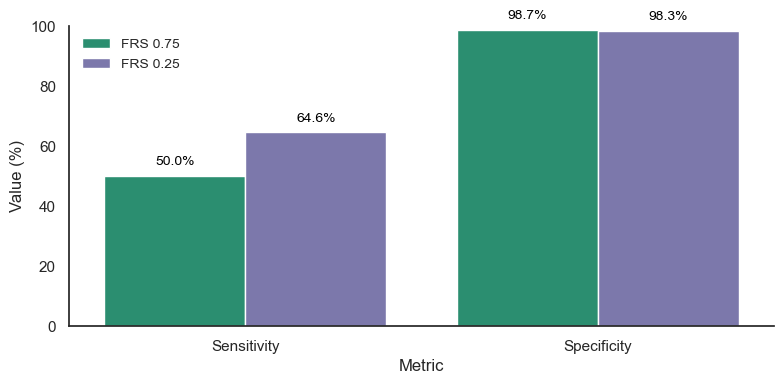

In [22]:
# ( i need this figure for the Bruge talk - who performance on our dataset)
performance = {
    "FRS 0.75":{"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    "FRS 0.25":{"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
}

utils.compare_metrics(performance, figsize=(8, 4))

## Discrepancy analysis between WHOv2 and our catalogue

What is the difference between the WHO catalogue and our catalogue/

WHOv2 contains aggregate rules, and therefore comparing acorss catalogues requires piezo to parse the rules.

mmpL5 is entirely susceptible in both WHOv2 (aside from LOFs, which are catalogued uncertain) and our catalogue - therefore, there's no point comparing them

In [38]:
#read in the WHO catalogue, and clean (U's are as meangingless as non-catalogued, so can discard)
who = pd.read_csv('./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv')
who_bdq = who[(who.DRUG=='BDQ')&(who.PREDICTION.isin(['R', 'S']))].copy()
who_bdq['PREDICTION_VALUES'] = 'RS'

# Convert evidence entries to dicts, and remove wildcard rows
who_bdq = who_bdq[~who_bdq['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]

print ('Number of variants or rules classified Resistant in the WHOv2 catalogue:', len(who_bdq[who_bdq.PREDICTION=='R']))
print ('Number of variants or rules classified Susceptible in the WHOv2 catalogue:', len(who_bdq[who_bdq.PREDICTION=='S']))

Number of variants or rules classified Resistant in the WHOv2 catalogue: 38
Number of variants or rules classified Susceptible in the WHOv2 catalogue: 2


In [39]:
#read in our catalogue, and clean (U's are as meangingless as non-catalogued, so can discard)
mmm_75 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')
mmm_75 = mmm_75[mmm_75.PREDICTION.isin(['R', 'S'])]

# Convert evidence entries to dicts, and remove wildcard rows
mmm_75 = mmm_75[~mmm_75['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]

#mmpL5 and mmpS5 all come out as susceptible in both catalogues, therefore not much point comparing (and the parsed catalogues don't contain them)
mmm_75 = mmm_75[~mmm_75.index.isin([i for i in mmm_75.index if mmm_75['MUTATION'][i].split('@')[0] in ['mmpL5', 'mmpS5']])]

print ('Number of variants or rules classified Resistant in our catalogue:', len(mmm_75[mmm_75.PREDICTION=='R']))
print ('Number of variants or rules classified Susceptible in our catalogue:', len(mmm_75[mmm_75.PREDICTION=='S']))

Number of variants or rules classified Resistant in our catalogue: 66
Number of variants or rules classified Susceptible in our catalogue: 0


In [40]:
# we can use piezo to compare catalogues as it can implicitly compare fine grain mutation declrations with coarse grain rules
# e.g) does Rv0678@V1? match Rv0678@V1Q?

#export cleaned WHOv2 and read back in for piezo load
who_bdq.to_csv("./catalogues/temp/WHOv2_adapted.csv")
catalogue = piezo.ResistanceCatalogue("./catalogues/temp/WHOv2_adapted.csv")

matched = {"shared": [], "not_shared": []}
for var in mmm_75.MUTATION:
    #for each mutation in our catalogue...
    try:
        if catalogue.predict(var)["BDQ"] in ["R", "S"]:
            # matched (and either R or S = actually catalogued)
            matched["shared"].append(var)
        else:
            #'U'
            matched["not_shared"].append(var)
    except ValueError:
        matched["not_shared"].append(var)

print ('Number of shared variants across catalogues:', len(matched['shared']))


Number of shared variants across catalogues: 40


But these do not necessarily share the same phenotypes... how many of these have phenotype discrepencies?

Rv0678@c-11a


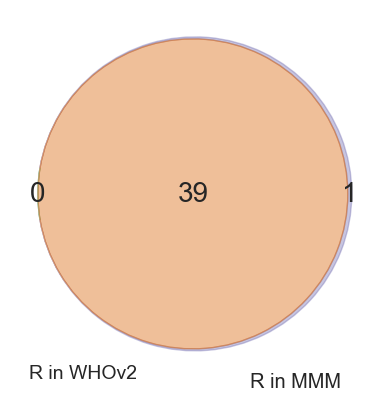

In [41]:
#load catalogue with piezo
catalogue = piezo.ResistanceCatalogue("./catalogues/temp/who_bdq_adapted.csv")

pheno_matched = {'shared':[], 'R_mmm':[], 'S_mmm':[]}
#iterate over mutations in our catalogue
for mut in mmm_75.itertuples(index=False):
    mutation, mmm_predict = mut.MUTATION, mut.PREDICTION
    try:
        #classify them with piezo
        who_predict = catalogue.predict(mutation).get('BDQ')
        if who_predict != 'U':
            if who_predict == mmm_predict:
                #matched
                pheno_matched['shared'].append(mutation)
            elif who_predict == 'R' and mmm_predict == 'S':
                #not matched
                pheno_matched['S_mmm'].append(mutation)
            elif who_predict == 'S' and mmm_predict == 'R':
                #not matched
                print (mutation)
                pheno_matched['R_mmm'].append(mutation)
    except ValueError:
        continue
    
#generate venn diagram for variants present in both catalogues
utils.plot_tricolour_venn((len(pheno_matched['S_mmm']), len(pheno_matched['R_mmm']), len(pheno_matched['shared'])), ['R in WHOv2', 'R in MMM'])


There is only 1 shared mutation that is Resistant in our catalogue but susceptible in the WHO catalogue - Rv0678@c-11a, which in our data as an 18% resistance proportion of solos, with relatively tight confidence intervals.

These are for shared variants, but what about mutations that are not present in both... how many additional mutations do each catalogue contain?

In [42]:
#which variants only exist in WHOv2 (need to remove aggregates, as these could constitute any number of variants)
wildcard_chars = {'*', '?', '='}
who_only = who_bdq[~who_bdq['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
who_only = [i for i in who_only if not any(c in i for c in wildcard_chars)]

print ('Number of mutations in WHOv2 only (not counting aggregates or mmpL5/mmpS5):', len(who_only))

Number of mutations in WHOv2 only (not counting aggregates or mmpL5/mmpS5): 19


In [43]:
mmm_75_all = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')

print ('number of these variants that are U in our catalogue:', len(mmm_75_all[mmm_75_all.MUTATION.isin(who_only)]))
print ('number of these variants that were not encountered:', len(who_only)- len(mmm_75_all[mmm_75_all.MUTATION.isin(who_only)]))

number of these variants that are U in our catalogue: 7
number of these variants that were not encountered: 12


However, all of these 12 are loss of function variants that fall under the WHO's aggregate rule - regarldess of whether they have been seen or not. We have not implemented such an expert rule.

In [44]:
mmm_only = mmm_75[~mmm_75['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
mmm_only = [i for i in mmm_only if not any(c in i for c in wildcard_chars)]
mmm_only

print ('Number of mutations in our catalogue only (not counting aggregates or mmpL5/mmpS5):', len(mmm_only))

Number of mutations in our catalogue only (not counting aggregates or mmpL5/mmpS5): 26


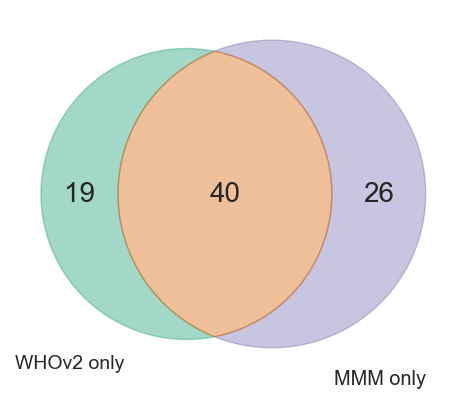

In [45]:
utils.plot_tricolour_venn((len(who_only), len(mmm_only), len(matched['shared'])), ['WHOv2 only', 'MMM only'])


Therefore, our catalogue contains 26 additional non-LOF Rv0678, pepQ, and atpE variants catalogued as resistant. 

The WHOv2 catalogue contains 7 variants catalogued as Resistant, that we have entered as U due to lack of evidence as they only occur once or occur twice with 1:1 R vs S. It also contains 12 LOF variants that fall under the WHOv2's aggregate expert rule that we miss as we have not implemented a rule.

Of the 40 shared variants, there is only 1 phenotype discrepency.


## We can build catalogues as a function of FRS

Up until now, we have followed the WHO's strategy of building at FRS 0.75 and testing at FRS 0.75 and 0.25. 

Surely its more sensible to also build at FRS 0.25 - if minor alleles are clinically significant and contribute to resistance, then those that exclusively exist at lower FRS should be included in the catalogue. If they are relevant, then they should all be captured. 

One of the benefifts of a deterministic alogorithmic approach is we can easily construct our catalogues as a function of FRS and compare performance across the entire FRS range. To allow max number of samples in for validation, lets drop our test FRS to 0.1

In [46]:
results = []

for i in np.arange(0.1, 1, 0.01):
    # Build and save catalogue across FRS range
    catalogue_name = f"BDQ-FRS-{int(i*100)}-2024.06"
    csv_path = f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv"
    
    catalogue =  BuildCatalogue(samples, cat_mutations, FRS=i, seed=['mmpL5@I948V', 'mmpL5@T794I'], test='Binomial', tails='two', strict_unlock=True, background=0.1)
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv")
    
    # Predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all, 
        csv_path, 
        "BDQ", 
        Print=False, 
        U_to_S=True
    )
    
    results.append((i, _sens * 100, _spec * 100, _cov * 100, _FN_ids))

# Create DataFrame
data = pd.DataFrame(results, columns=["FRS", "Sensitivity", "Specificity", "Coverage", "FNs"])

# Plot the results


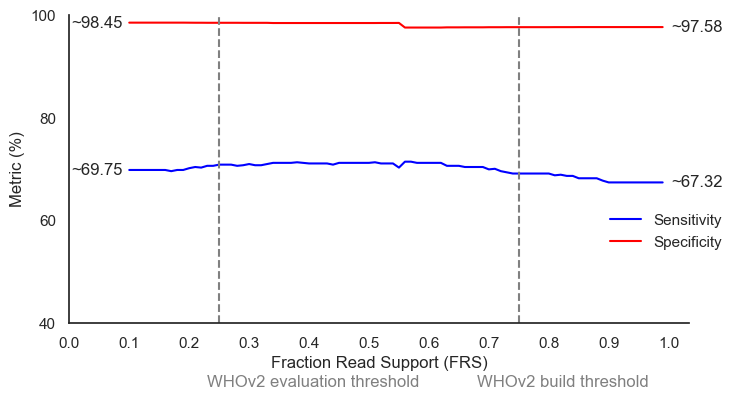

In [47]:
utils.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False)

We see a slight drop in sensitivity as FRS increases - its very shallow and gradual. Is this because we are missing minor alleles that are in fact clinically relevant when setting the FRS high?

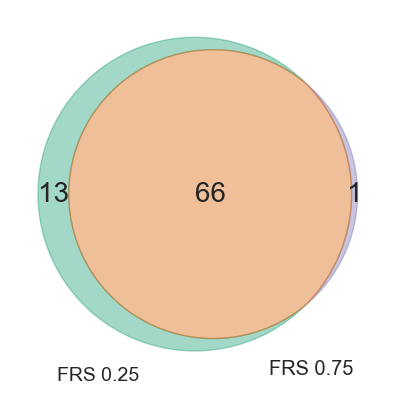

In [48]:
#Compare catalogues built at FRS 0.25 vs 0.75

catalogue25 = pd.read_csv('./catalogues/manuscript/var_frs/catalogue_FRS_25.csv')
catalogue25 = catalogue25[catalogue25.PREDICTION.isin(['R'])]
catalogue25 = catalogue25[~catalogue25['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]

catalogue75 = pd.read_csv('./catalogues/manuscript/var_frs/catalogue_FRS_75.csv')
catalogue75 = catalogue75[catalogue75.PREDICTION.isin(['R'])]
catalogue75 = catalogue75[~catalogue75['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]

shared = pd.merge(catalogue25, catalogue75, on='MUTATION', how='inner')['MUTATION'].unique()
unique25 = catalogue25[~catalogue25['MUTATION'].isin(shared)]['MUTATION'].unique()
unique75 = catalogue75[~catalogue75['MUTATION'].isin(shared)]['MUTATION'].unique()

utils.plot_tricolour_venn((len(unique25), len(unique75), len(shared)), ['FRS 0.25', 'FRS 0.75'])

The catalogue built at lower FRS contains 13 additional resistant variants to the catalogue built at FRS 0.75 - these explain the slight boost in sensitivity.

This strongly suggests relevant variants can exist at lower read support, and must be considered.

## mmpL5 variants are classified Susceptible

mmpL5 is exclusively classified susceptible in both WHOv2 and our catalogue, and `methods.ipynb` details the fact that all mmpL5 solo variants are homogeneously susceptible:

In [49]:
catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_10.csv')
catalogue_01_df = catalogue_01_df[~catalogue_01_df['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]
utils.plot_catalogue_counts(all, catalogue_01_df)

IndexError: single positional indexer is out-of-bounds

There is little evidence either mmpL5 nor mmpS5 should be considered candidate genes when building resistance catalogues for Bedaquiline, with the exception of epistasis rules.

We should be able to build a catalogue without either gene and observe no negative impact on performance...

In [50]:
#remove mmpL5 and mmpS5 from validation set
all = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])], how='left', on='UNIQUEID')
#remove mmpL5 and mmpS5 from mut666ations df for catalogue building
cat_mutations = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]

In [51]:
no_mmpL5_results = []

for i in np.arange(0.1, 1, 0.01):
    # Build and save catalogue across FRS range
    catalogue_name = f"BDQ-FRS-{int(i*100)}-2024.06"
    csv_path = f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv"
    
    catalogue =  BuildCatalogue(samples, cat_mutations, FRS=i, test='Binomial', tails='two', strict_unlock=True, background=0.1)
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv")
    
    # Predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all, 
        csv_path, 
        "BDQ", 
        Print=False, 
        U_to_S=True
    )
    
    no_mmpL5_results.append((i, _sens * 100, _spec * 100, _cov * 100, _FN_ids))

# Create DataFrame
data = pd.DataFrame(no_mmpL5_results, columns=["FRS", "Sensitivity", "Specificity", "Coverage", "FNs"])

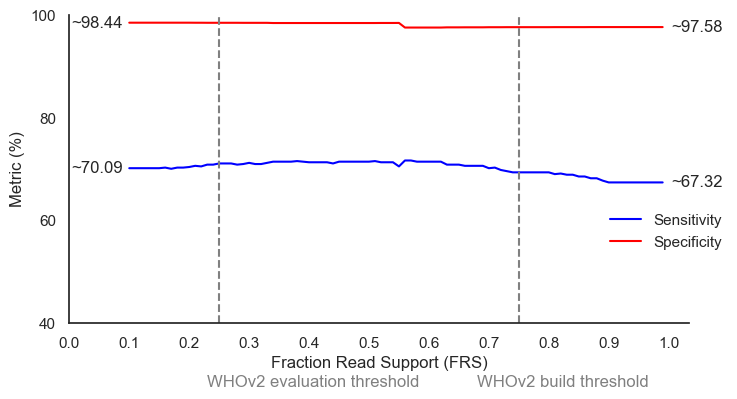

In [52]:
utils.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False)

# Comparison of reporting U's vs hiding them in the S column

For reasons explained in methods.ipynb, we should keep are uncertain classifications seperate, not only in the catalogue, but also following through to the predictions. Samples with a U or with an uncatalogued mutation must also be predicted U. This is not the protocol the WHO have followed, so let's compare them to see how many susceptible predictions can be accounted for by the assumption.

We can just read in the same catalogue:

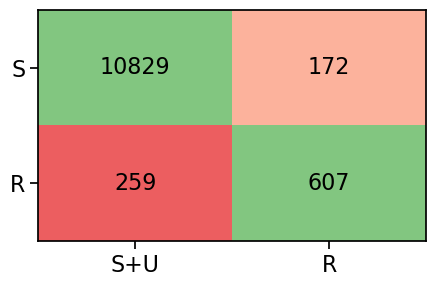

In [15]:
  
# Predict with catalogue at FRS 0.1 - MERGE S AND U
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
    all, 
    './catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv', 
    "BDQ", 
    Print=False, 
    U_to_S=True
)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True, figsize=(5, 3), fontsize=16)

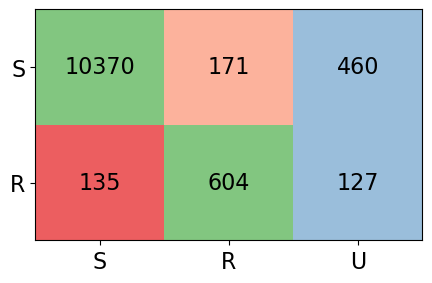

In [14]:
#now predict with catalogue at FRS 0.1 - KEEP Us seperate
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
    all, 
    './catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv', 
    "BDQ", 
    Print=False, 
    U_to_S=False
)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm, U_to_S=False, figsize=(5, 3), fontsize=16)

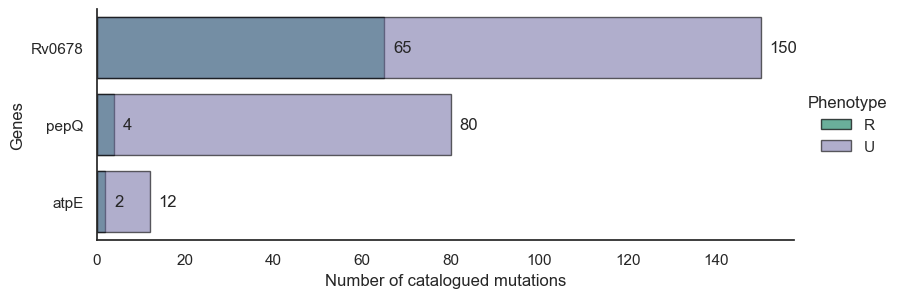

In [16]:
#in our largest catalogue, how many U's do we have? Ie, what accounts for those 460 + 127 U predictions?
cat = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv')
cat = cat[~cat['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]

utils.plot_catalogue_counts(all, cat, figsize=(9, 3))

In [17]:
cat

,Unnamed: 0,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,313,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@*=,S,{},"{""default_rule"": ""True""}",{}
1,319,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,pepQ@*=,S,{},"{""default_rule"": ""True""}",{}
2,325,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,mmpS5@*=,S,{},"{""default_rule"": ""True""}",{}
3,331,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@*=,S,{},"{""default_rule"": ""True""}",{}
4,337,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,atpE@*=,S,{},"{""default_rule"": ""True""}",{}
...,...,...,...,...,...,...,...,...,...,...,...,...
338,338,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
339,339,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
340,340,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
341,341,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


## Cross-validated catalogue

We should present a catalogue that we can confident in and has attributes we consider suitable to the data at hand. To determine the level of uncertainty nin the classifications properly, we ideally need an independent validation set, which we sadly do not have.

What we can do however, is use cross-validation to achieve some level of confidence. We will use 5 folds with 80:20 train:test splits.

Attributes:
- No mmpL5 or mmpS5 (perhaps include an epistatic link wildcard)
- FRS 0.1 to capture all variants, assuming minor alleles are clinically significant
- Make no assumptions about U variants
- Keep U samples seperate and report as an additional metric, 'coverage'.
- Piezo compatible - standardised format for easy, reproducible parsing.
- Cross validated (5 fold)
- Contingency table included in 'evidence column'
- All data published with a reproducible pipeline

Limitations:
- Validated on the training set - poor, but we don't have enough data to create an independent test set

In [15]:
#remove mmpL5 and mmpS5 from validation set
all = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])], how='left', on='UNIQUEID')
#remove mmpL5 and mmpS5 from mutations df for catalogue building
cat_mutations = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]
all.reset_index(inplace=True)
samples.reset_index(inplace=True)

Performance for 5-fold cross-validated catalogue:

isolate_cov (0.9424599831508003, 0.00397476869825964)
specificity (0.984612678426646, 0.0025858966078588477)
sensitivity (0.7936076553683111, 0.017675875563593523)


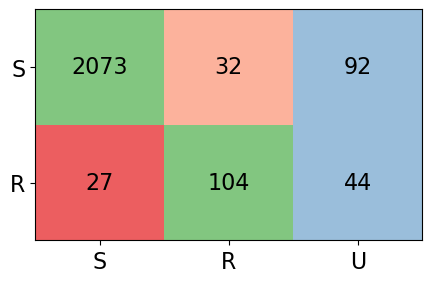

In [16]:
X = all.UNIQUEID.unique()

rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
train_indices, test_indices = [], []
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = cat_mutations[cat_mutations.UNIQUEID.isin(train_ids)]
    test_df = all[all.UNIQUEID.isin(test_ids)]

    BuildCatalogue(
        train_samples,
        train_mutations,
        FRS=0.1,
        test="Binomial",
        tails="two",
        strict_unlock=True,
        background=0.1,
    ).to_piezo(
        "NC_000962.3",
        "BDQ-FRS-0.1-2024.06",
        '1.1',
        "BDQ",
        piezo_wildcards,
        outfile=f'./catalogues/manuscript_2/cv/fold_{str(fold)}.csv',
    )

    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        test_df, 
        f"./catalogues/manuscript_2/cv/fold_{str(fold)}.csv", 
        "BDQ", 
        Print=False, 
        U_to_S=False
    )
    isolate_cov.append(_cov)
    specificities.append(_spec)
    # just for the sake of plotting the bar charts - a nan would make plotting impossible
    sensitivities.append(_sens)
    cms.append(cm)

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

mean = np.mean(cms, axis=0)

labels = [[], []]
for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))

df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])

print ('Performance for 5-fold cross-validated catalogue:\n')

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)

utils.plot_truthtables(df_cm, U_to_S=False, figsize=(5, 3), fontsize=16)

### Position counts plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


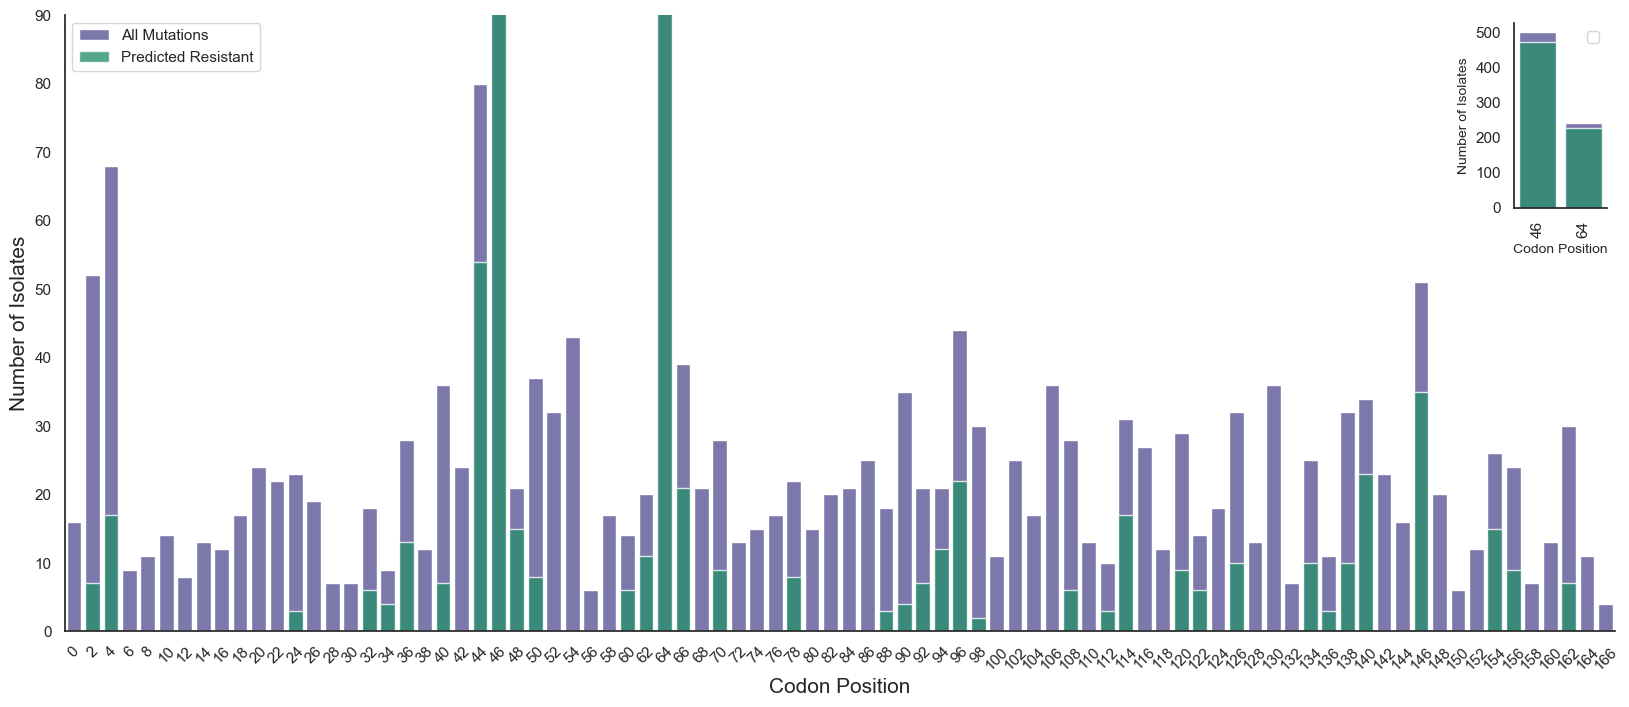

In [156]:
cat = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv')
cat = cat[~cat['EVIDENCE'].apply(utils.str_to_dict).apply(lambda x: 'default_rule' in x)]
cat = cat[cat.PREDICTION=='R']


# Load the mutations data
rv0678 = mutations[mutations.GENE == 'Rv0678'].copy()

# Add the IS_CATALOGUED column
rv0678['IS_CATALOGUED'] = rv0678.apply(
    lambda row: True if row['MUTATION'] in cat.MUTATION.tolist() else False,
    axis=1
)

# Update 'GENE_POSITION' based on conditions
rv0678['GENE_POSITION'] = rv0678.apply(
    lambda row: row['GENE_POSITION'] / 3 if pd.notna(row['NUCLEOTIDE_NUMBER']) else row['GENE_POSITION'],
    axis=1
)

# Ensure 'GENE_POSITION' is numeric
rv0678['GENE_POSITION'] = pd.to_numeric(rv0678['GENE_POSITION'], errors='coerce')

# Remove any positions that may have become negative or invalid
rv0678 = rv0678[rv0678['GENE_POSITION'] >= 0]

# Group positions by pairs (0, 2, 4, etc.)
rv0678['GROUPED_POSITION'] = (rv0678['GENE_POSITION'] // 2) * 2

# Create a complete range of grouped codon positions
all_grouped_positions = range(int(rv0678['GROUPED_POSITION'].min()), int(rv0678['GROUPED_POSITION'].max()) + 1, 2)
mutation_counts_grouped = rv0678['GROUPED_POSITION'].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

# Calculate IS_CATALOGUED counts
catalogued_counts_grouped = rv0678[rv0678['IS_CATALOGUED']]['GROUPED_POSITION'].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Main plot with all mutations
sns.barplot(x=mutation_counts_grouped.index, y=mutation_counts_grouped.values, color='#7570b3', ax=ax, label='All Mutations')

# Overlay with IS_CATALOGUED mutations
sns.barplot(x=catalogued_counts_grouped.index, y=catalogued_counts_grouped.values, color="#1b9e77", ax=ax, alpha=0.8, label='Predicted Resistant')

plt.ylabel('Number of Isolates', fontsize=15)
plt.xlabel('Codon Position', fontsize=15)
plt.legend(loc='upper left', frameon=False)
ax.legend(frameon=False)






ax.xaxis.set_tick_params(rotation=45)

# Highlight the really long bars
high_counts = mutation_counts_grouped[mutation_counts_grouped > 90]
ax.set_ylim(0, 90)

# Create an inset plot
ax_inset = inset_axes(ax, width="6%", height="30%", loc='upper right')
sns.barplot(x=high_counts.index, y=high_counts.values, color='#7570b3', ax=ax_inset)
sns.barplot(x=high_counts.index, y=catalogued_counts_grouped[high_counts.index], color="#1b9e77", ax=ax_inset, alpha=0.8)

ax_inset.set_xlabel('Codon Position', fontsize=10)
ax_inset.set_ylabel('Number of Isolates', fontsize=10)
ax_inset.set_xticklabels(ax_inset.get_xticklabels(), rotation=90)

# Remove top and right spines from both the main plot and the inset
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    ax_inset.spines[spine].set_visible(False)

plt.ylabel('Number of Isolates')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [127]:
rv0678[rv0678.IS_CATALOGUED]

,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,IS_SYNONYMOUS,IS_CATALOGUED,GROUPED_POSITION
UNIQUEID,,,,,,,,,,,,,,,,,,,
site.01.subj.DR0650.lab.DR0650.iso.1,Rv0678,Rv0678@R50Q,cgg,cag,NaN,NaN,50.000000,True,NaN,NaN,50.0,Q,1.0,False,NaN,1.000,False,True,50.0
site.01.subj.DR0053.lab.DR0053.iso.1,Rv0678,Rv0678@E55D,gaa,gac,NaN,NaN,55.000000,True,NaN,NaN,55.0,D,1.0,False,NaN,1.000,False,True,54.0
site.01.subj.DR0597.lab.DR0597.iso.1,Rv0678,Rv0678@142_ins_t,NaN,NaN,142.0,779131.0,47.333333,True,1.0,t,NaN,NaN,NaN,False,NaN,1.000,False,True,46.0
site.01.subj.DR0598.lab.DR0598.iso.1,Rv0678,Rv0678@G24S,ggc,agc,NaN,NaN,24.000000,True,NaN,NaN,24.0,S,1.0,False,NaN,1.000,False,True,24.0
site.01.subj.DR0636.lab.DR0636.iso.1,Rv0678,Rv0678@E55D,gaa,gac,NaN,NaN,55.000000,True,NaN,NaN,55.0,D,1.0,False,NaN,1.000,False,True,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.07.subj.50A5C179-9CD4-4B8A-BE2F-F46DBA17C350.lab.50A5C179-9CD4-4B8A-BE2F-F46DBA17C350.iso.1,Rv0678,Rv0678@Y26H,tat,zzz,NaN,NaN,26.000000,True,NaN,NaN,26.0,H,1.0,True,Y26H,0.333,False,True,26.0
site.07.subj.FD_127_675.lab.15.iso.1,Rv0678,Rv0678@V85A,gtc,gcc,NaN,NaN,85.000000,True,NaN,NaN,85.0,A,1.0,False,NaN,1.000,False,True,84.0
site.07.subj.01F1FA4C-6BC1-482A-9202-D59288683A06.lab.01F1FA4C-6BC1-482A-9202-D59288683A06.iso.1,Rv0678,Rv0678@I108V,atc,zzz,NaN,NaN,108.000000,True,NaN,NaN,108.0,V,1.0,True,I108V,0.500,False,True,108.0


In [114]:
cat

,Unnamed: 0,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
5,5,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@192_ins_g,R,{},"[{""proportion"": 0.4230769230769231, ""confidenc...",{}
6,12,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@I67L,R,{},"[{""proportion"": 1.0, ""confidence"": [0.34238022...",{}
7,29,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@Q115!,R,{},"[{""proportion"": 0.75, ""confidence"": [0.3006418...",{}
8,33,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@465_ins_c,R,{},"[{""proportion"": 0.75, ""confidence"": [0.3006418...",{}
9,45,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@141_ins_c,R,{},"[{""proportion"": 0.8266666666666667, ""confidenc...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...
313,308,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@372_del_g,U,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.793...",{}
314,309,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@138_ins_ga,U,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}
315,310,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@G103R,U,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}
316,311,NC_000962.3,BDQ-FRS-10-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@167_del_tggcgacggcgctggcggccagcagcggggg...,U,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}


In [111]:
cat.MUTATION

5                                       Rv0678@192_ins_g
6                                            Rv0678@I67L
7                                           Rv0678@Q115!
8                                       Rv0678@465_ins_c
9                                       Rv0678@141_ins_c
                             ...                        
313                                     Rv0678@372_del_g
314                                    Rv0678@138_ins_ga
315                                         Rv0678@G103R
316    Rv0678@167_del_tggcgacggcgctggcggccagcagcggggg...
317                                          Rv0678@R38L
Name: MUTATION, Length: 313, dtype: object

We partly achieve  high sensitivity under cross validation because although there is variation, a number of resistant mutations do dominate through the folds. 

In [ ]:
all["MIC_FLOAT"] = utils.mic_to_float(all["METHOD_MIC"].tolist())

catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv')

R_muts = catalogue_01_df[catalogue_01_df.PREDICTION == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.MUTATION.isin(R_muts))]) == 1:
        solo_Rs.append(i)

df = pd.DataFrame.from_dict(
    {
        "MUTATION": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].MUTATION.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

print(
    {
        "MUTATION": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].MUTATION.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]

df["MIC"] = [str(i) for i in df.MIC]

{'MUTATION': ['Rv0678@192_ins_g', 'Rv0678@I67L', 'Rv0678@141_ins_c', 'Rv0678@R134!', 'Rv0678@16_del_g', 'Rv0678@Q115!', 'Rv0678@465_ins_c', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@132_ins_gt', 'Rv0678@141_ins_c', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@491_ins_cg', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@P48L', 'Rv0678@P48L', 'Rv0678@192_ins_g', 'Rv0678@G121R', 'Rv0678@L136P', 'Rv0678@141_ins_c', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@465_ins_c', 'Rv0678@192_ins_g', 'Rv0678@A36V', 'Rv0678@141_ins_c', 'Rv0678@192_ins_g', 'Rv0678@138_ins_g', 'Rv0678@C46R', 'Rv0678@140_ins_tc', 'Rv0678@138_ins_g', 'Rv0678@464_ins_gc', 'Rv0678@138_ins_g', 'Rv0

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46835/233797858.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_46835/233797858.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(


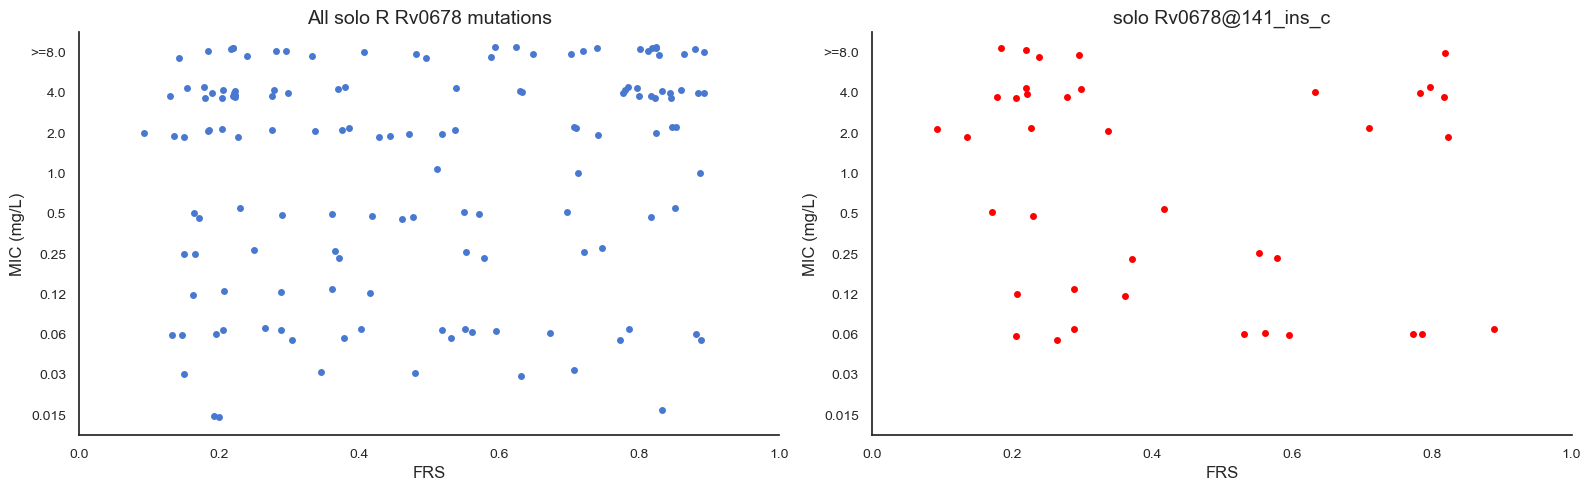

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.set_context("paper")

# axes[0].set_ylim(0, 3.5)
y_axis_order = [
    "0.015",
    "0.03",
    "0.06",
    "0.12",
    "0.25",
    "0.5",
    "1.0",
    "2.0",
    "4.0",
    "8.0",
]

sns.stripplot(
    x="FRS", y="MIC", data=df[df.FRS < 0.9], ax=axes[0], jitter=0.15, order=y_axis_order
)
axes[0].set_title("All solo R Rv0678 mutations", fontsize=14)
axes[0].invert_yaxis()
axes[0].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)
axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("MIC (mg/L)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)


axes[0].set_xlim(0, 1)

sns.stripplot(
    x="FRS",
    y="MIC",
    data=df[(df.MUTATION == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    jitter=0.15,
    color="red",
    order=y_axis_order,
)
axes[1].set_title("solo Rv0678@141_ins_c", fontsize=14)
axes[1].invert_yaxis()
axes[1].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)

axes[1].set_xlim(0, 1)
# axes[1].set_ylim(0, 3.5)
axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("MIC (mg/L)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Adjust layout
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

There is no correlation between FRS and MIC for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. It would be interesting to analyse growth data from the plates, however this data is not available.

## Is there a correlation between FRS and Growth?

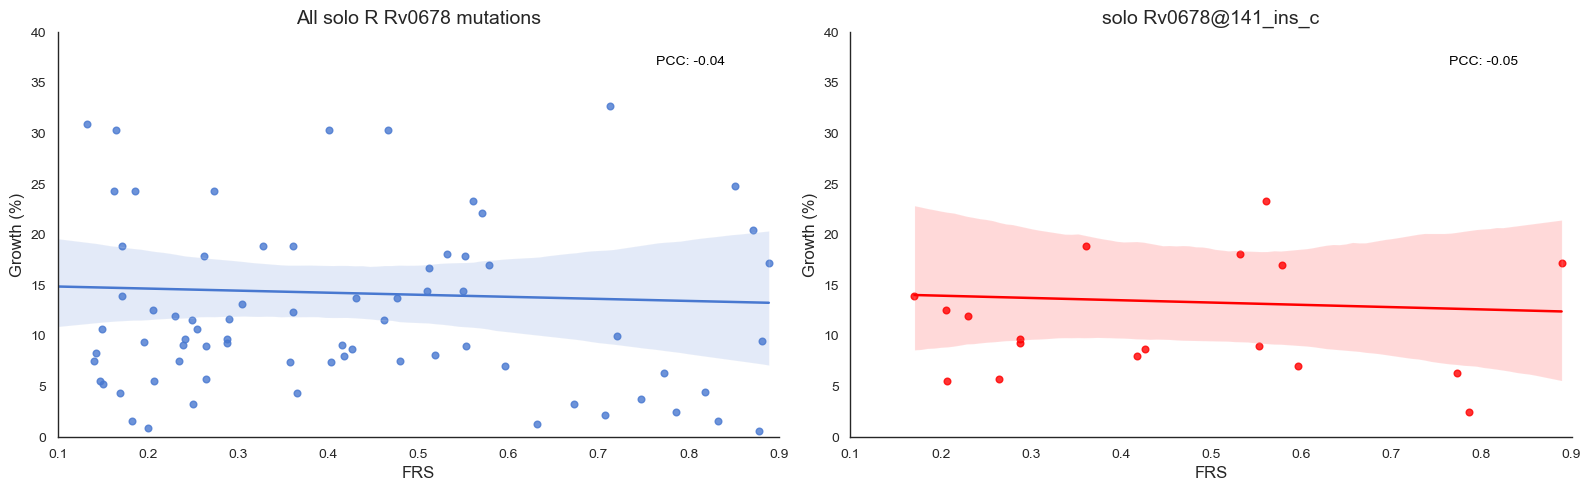

In [ ]:
growth_dil = growth[(growth.DILUTION.isin([1, 2, 3])) & (growth.READINGDAY == 14)]
# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at growth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions

df = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df = df[df.UNIQUEID.isin(solo_Rs)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.regplot(x="FRS", y="GROWTH", data=df[df.FRS < 0.9], ax=axes[0], ci=95)
axes[0].set_title("All solo R Rv0678 mutations", fontsize=14)
axes[0].set_xlim(0.1, 0.9)
axes[0].set_ylim(0, 40)

axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("Growth (%)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)

# Calculate Pearson correlation coefficient
pcc_value = df[df.FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]

# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df[(df.MUTATION == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    color="red",
    ci=95,
)
axes[1].set_title("solo Rv0678@141_ins_c", fontsize=14)
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range
axes[1].set_ylim(0, 40)

axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("Growth (%)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Calculate Pearson correlation coefficient
pcc_value = (
    df[(df.FRS < 0.9) & (df.MUTATION == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)

# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)
sns.despine()

# Adjust layout
plt.tight_layout()


# Can we aggreage variants under a rule?

The WHO have used aggregate rules for all loss of function mutations in Rv0678 and pepQ, solely based off literature evidence. The question is, does the data suggest this approach is valid and should we be doing the same?   

If we can demonstrate sufficient phenotype homogeneity and a strong mean penetration, then an additional aggregate rule could be justified. 

However 4/22 and 70/324 Rv0678 premature stops and frameshifts are susceptible (in the catalogue), which seems quite high if we're going to assume they all have the same effect:

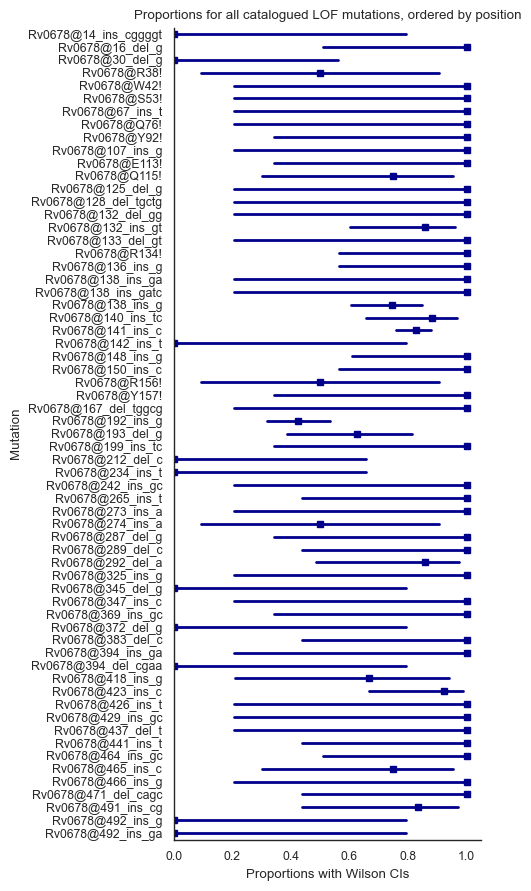

In [ ]:
rules = ["*_fs", "*!"]

catalogue = pd.read_csv("catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv")

lofs = []
# its easier to use piezo on a csv file, but easier to plot from a dictionary
#thereforew, we will find lofs with piezo and then work with a fresh catalogue
for rule in rules:
    aggregate_rule = piezo.ResistanceCatalogue(f"./temp/bdq_Rv0678@{rule}.csv")
    for i in catalogue.index:
        mutation = catalogue["MUTATION"][i]

        if (mutation != aggregate_rule) and (mutation not in piezo_wildcards.keys()):
            if aggregate_rule.predict(mutation)["BDQ"] == "R":
                lofs.append(mutation)
#build the catalogue using same parameters from the above   
catalogue = BuildCatalogue(
    samples=samples,
    mutations=cat_mutations,
        FRS=0.1,
        test="Binomial",
        tails="two",
        strict_unlock=True,
        background=0.1,
).return_catalogue()

catalogue = {k: v for k, v in catalogue.items() if 'seeded' not in v['evid'] and k in lofs}

def extract_position(key):
    parts = key.split('@')[1]
    position = "".join(filter(str.isdigit, parts.split("_")[0]))
    return int(position)

# Sort the dictionary by position
catalogue = dict(sorted(catalogue.items(), key=lambda item: extract_position(item[0]), reverse=True))

utils.plot_catalogue_proportions(catalogue, figsize=(5, 9), order=False, title='Proportions for all catalogued LOF mutations, ordered by position')

                